Parte 1 - Infraestrutura
======================
Para as questões a seguir, você deverá executar códigos em um notebook Jupyter, rodando em ambiente local, certifique-se que:

In [3]:
import sys
import os
import pkg_resources
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import sklearn.utils
import scipy.cluster.hierarchy as sch

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.stats import zscore
from scipy.spatial.distance import cdist

%matplotlib inline
warnings.filterwarnings('ignore')

### 1. Você está rodando em Python 3.9

In [5]:
print("Python version:", sys.version)

Python version: 3.9.20 (main, Oct  3 2024, 07:27:41) 
[GCC 11.2.0]


### 2. Você está usando um ambiente virtual: Virtualenv ou Anaconda

In [7]:
if 'CONDA_DEFAULT_ENV' in os.environ:
    print("Usando o conda no ambiente: ", os.environ['CONDA_DEFAULT_ENV'])
else:
    print("Não está usando o conda.")
    
print("Caminho do Python:", sys.prefix)


Usando o conda no ambiente:  clusterizacao
Caminho do Python: /home/c86d0990-2dfb-41eb-8d59-4923840cb130/.conda/envs/clusterizacao


### 3. Todas as bibliotecas usadas nesse exercícios estão instaladas em um ambiente virtual específico

In [9]:
# pacotes instalados
installed_packages = pkg_resources.working_set
for package in installed_packages:
    print(package)

Pygments 2.15.1
asttokens 2.0.5
backcall 0.2.0
comm 0.2.1
contourpy 1.3.0
cycler 0.12.1
debugpy 1.6.7
decorator 5.1.1
exceptiongroup 1.2.0
executing 0.8.3
fonttools 4.54.1
importlib-metadata 7.0.1
importlib-resources 6.4.5
ipykernel 6.29.5
ipython 8.15.0
jedi 0.19.1
joblib 1.4.2
jupyter-client 8.6.0
jupyter-core 5.7.2
kiwisolver 1.4.7
matplotlib 3.9.2
matplotlib-inline 0.1.6
nest-asyncio 1.6.0
numpy 1.23.5
packaging 24.1
pandas 1.5.3
parso 0.8.3
pexpect 4.8.0
pickleshare 0.7.5
pillow 11.0.0
pip 24.2
platformdirs 3.10.0
prompt-toolkit 3.0.43
psutil 5.9.0
ptyprocess 0.7.0
pure-eval 0.2.2
pyparsing 3.2.0
python-dateutil 2.9.0.post0
pytz 2024.2
pyzmq 25.1.2
scikit-learn 1.5.2
scipy 1.13.1
seaborn 0.13.2
setuptools 75.1.0
six 1.16.0
stack-data 0.2.0
threadpoolctl 3.5.0
tornado 6.4.1
traitlets 5.14.3
typing-extensions 4.11.0
wcwidth 0.2.5
wheel 0.44.0
zipp 3.20.2
autocommand 2.2.2
backports.tarfile 1.2.0
inflect 7.3.1
jaraco.collections 5.1.0
jaraco.context 5.3.0
jaraco.functools 4.0.1
jarac

### 4. Gere um arquivo de requerimentos (requirements.txt) com os pacotes necessários. É necessário se certificar que a versão do pacote está disponibilizada.

In [11]:
cat requirements.txt

pandas==1.5.3            # Manipulação de dados
numpy>=1.20.3,<1.24.0    # Operações numéricas (exclui 1.24.0)
matplotlib>=3.7.1        # Visualização de gráficos
seaborn>=0.12.2          # Visualização estatística
scikit-learn>=1.2.0      # Algoritmos de clusterização (K-means, DBSCAN)
scipy>=1.10.0            # Análise hierárquica (dendogramas)


### 5. Tire um printscreen do ambiente que será usado rodando em sua máquina.


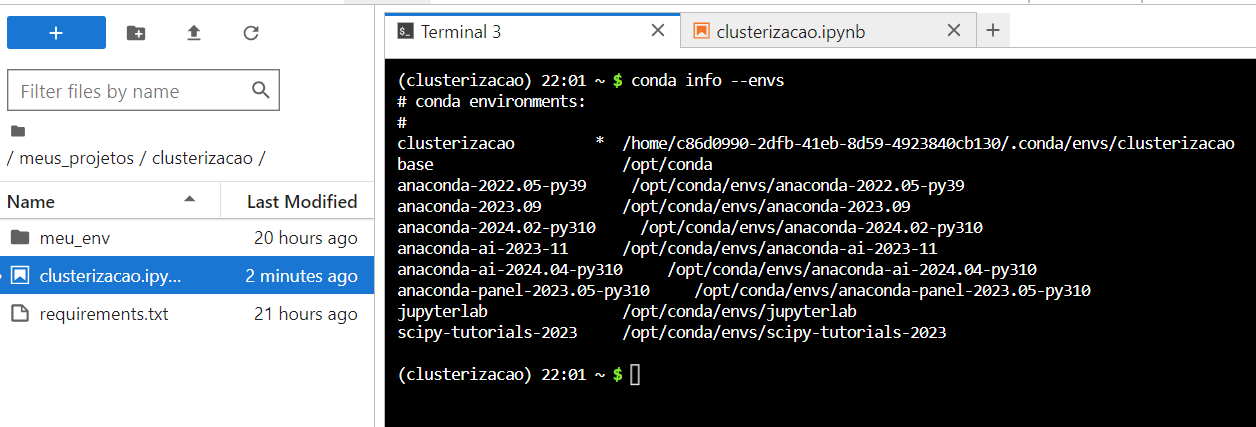

---

Parte 2 - Escolha de base de dados
======================
Para as questões a seguir, usaremos uma base de dados e faremos a análise exploratória dos dados, antes da clusterização.

### 1. Baixe os dados disponibilizados na plataforma Kaggle sobre dados sócio-econômicos e de saúde que determinam o índice de desenvolvimento de um país. Esses dados estão disponibilizados através do link: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data

In [17]:
# Caminho do arquivo CSV
file_path = '/home/c86d0990-2dfb-41eb-8d59-4923840cb130/meus_projetos/clusterizacao/Country-data.csv'

# Carregar o arquivo CSV
df = pd.read_csv(file_path)

# Exibir as primeiras linhas do DataFrame
print(df.head())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


### 2. Quantos países existem no dataset?

In [19]:
# Contar o número de países únicos
num_paises = df['country'].nunique()
print(f"Número de países no dataset: {num_paises}")

Número de países no dataset: 167


### 3. Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

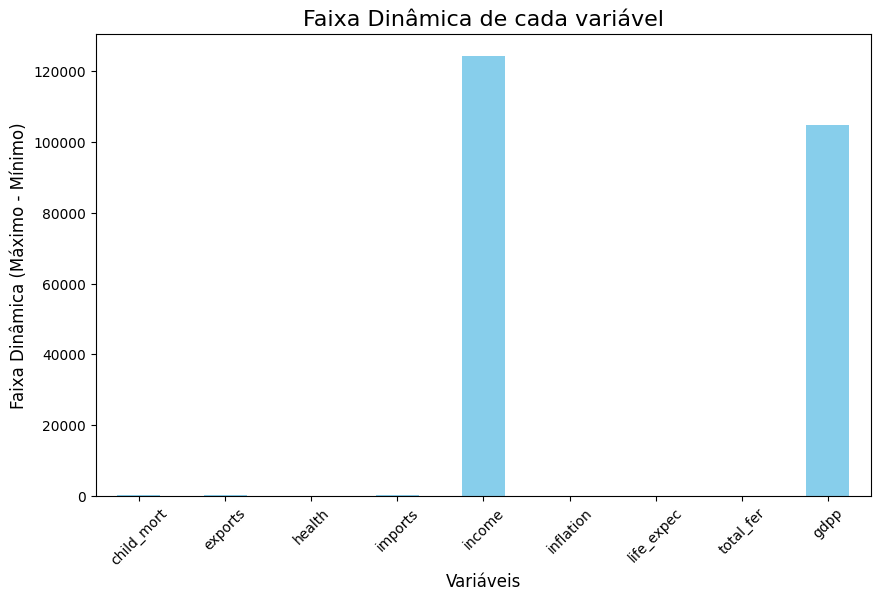

In [21]:
# Definindo as variáveis a serem analisadas
variaveis = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# Calculando a faixa dinâmica (máximo - mínimo) para cada variável
faixa_dinamica = df[variaveis].apply(lambda x: x.max() - x.min())

# Gráfico da faixa dinâmica
plt.figure(figsize=(10, 6))
faixa_dinamica.plot(kind='bar', color='skyblue')
plt.title('Faixa Dinâmica de cada variável', fontsize=16)
plt.xlabel('Variáveis', fontsize=12)
plt.ylabel('Faixa Dinâmica (Máximo - Mínimo)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

<span style="color:blue;">

##### Antes de fazer a clusterização, é importante tratar os outliers e a dispersão das variáveis. 
##### Isso pode incluir remover ou ajustar os valores extremos em variáveis como mortalidade infantil e PIB, além de normalizar dados com grande variação.
##### Essas ações ajudam a melhorar a qualidade da análise e garantem resultados mais consistentes na clusterização.

</span>

### 4. Realize o pré-processamento adequado dos dados.

##### 4.1. Tratamento de Valores Ausentes

In [25]:
# Verificando valores ausentes
missing_values = df.isnull().sum()
print("Valores ausentes por coluna:\n", missing_values)

# Substituindo valores ausentes com a média das colunas numéricas
df.fillna(df.mean(numeric_only=True), inplace=True)

# Verificando novamente se há valores ausentes
missing_values_after = df.isnull().sum()
print("\nValores ausentes após o tratamento:\n", missing_values_after)


Valores ausentes por coluna:
 country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Valores ausentes após o tratamento:
 country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


##### 4.2. Normalização/Escala dos Dados

In [27]:
# Criação do scaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

# Seleção das colunas a serem escaladas
columns_to_scale = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# Aplicação da padronização
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

##### 4.3. Detecção e Tratamento de Outliers

In [29]:
# Aplica o z-score
z_scores = np.abs(zscore(df[columns_to_scale]))

# Define um limiar de 3 (padrão para z-score)
outliers = (z_scores > 3)

# Exclui ou corrige outliers
df_no_outliers = df[~outliers.any(axis=1)]  # Exclui linhas com qualquer outlier

##### 4.4. Eliminação de Variáveis Irrelevantes

In [31]:
# Configuração do threshold de variância
selector = VarianceThreshold(threshold=0.01)  # 1% de variância

# Aplicando a seleção de variáveis
df_selected = selector.fit_transform(df[columns_to_scale])

---


Parte 3 - Clusterização
======================
Para os dados pré-processados da etapa anterior você irá:

### 1. Realizar o agrupamento dos países em 3 grupos distintos. Para tal, use:a. 
K-Média
<br>b. 
Clusterização Hierárquica

#### K-Média

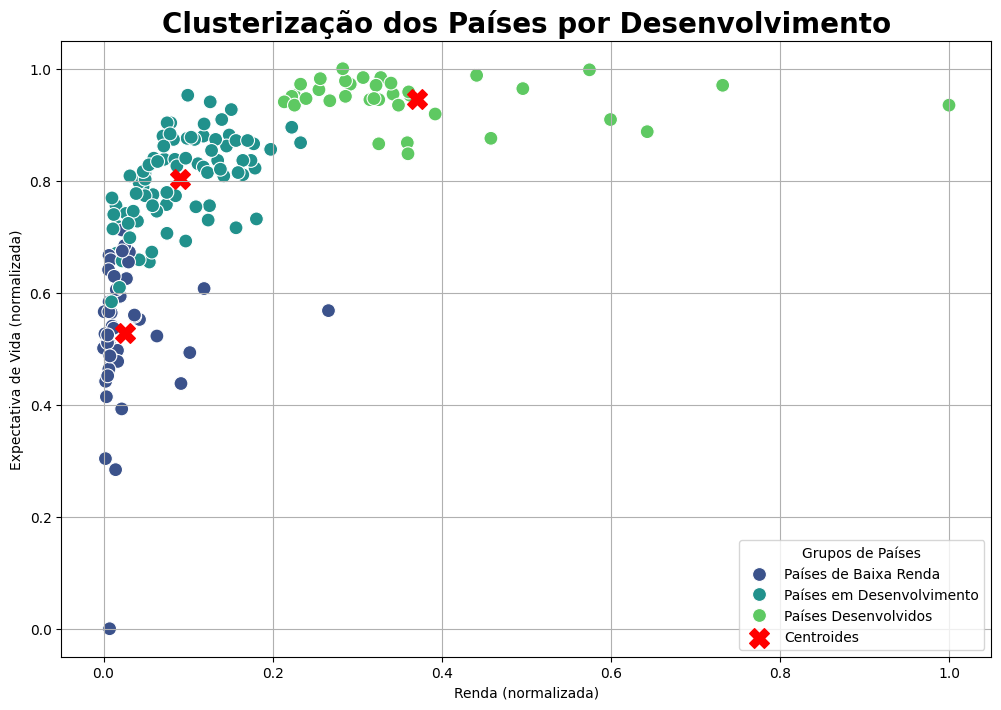

Silhouette Score: 0.515767362127356


In [36]:
# Garantir uso eficiente de CPU
os.environ["LOKY_MAX_CPU_COUNT"] = "2"  # núcleos

# Selecionando as colunas relevantes para a clusterização
columns_to_scale = ['child_mort', 'income', 'life_expec', 'gdpp']
X = df[columns_to_scale]

# Normalizando as colunas para a clusterização
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Inicializando o modelo KMeans com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X)

# Aplicando o modelo
df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# Visualizando os centros dos clusters
centroids = kmeans.cluster_centers_

# Definindo rótulos baseados na interpretação das características médias
cluster_labels = {
    0: "Países em Desenvolvimento",
    1: "Países Desenvolvidos",
    2: "Países de Baixa Renda"
}

# Atribuindo rótulos descritivos aos clusters
df['Cluster_Descrição'] = df['cluster_kmeans'].map(cluster_labels)

# Plotando os clusters com os rótulos interpretativos
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df[columns_to_scale[1]],  # 'income'
    y=df[columns_to_scale[2]],  # 'life_expec'
    hue=df['Cluster_Descrição'],
    palette='viridis',
    s=100
)

# Adicionando centróides ao gráfico
plt.scatter(
    centroids[:, 1],  # 'income'
    centroids[:, 2],  # 'life_expec'
    c='red',
    marker='X',
    s=200,
    label='Centroides'
)

plt.title("Clusterização dos Países por Desenvolvimento", fontweight='bold', fontsize=20)
plt.xlabel('Renda (normalizada)')
plt.ylabel('Expectativa de Vida (normalizada)')
plt.legend(title="Grupos de Países")
plt.grid(True)
plt.show()

silhouette_avg = silhouette_score(X_scaled, df['cluster_kmeans'])
print(f"Silhouette Score: {silhouette_avg}")

#### b. Clusterização Hierárquica


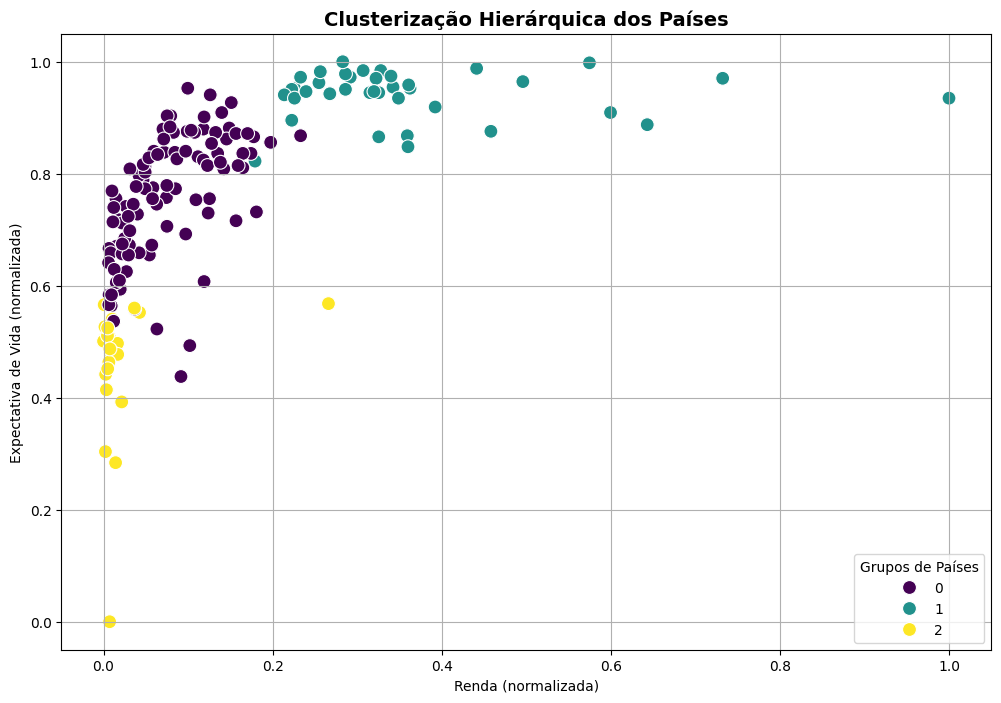

In [38]:
# Aplicando a clusterização hierárquica
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['cluster_hierarchical'] = hierarchical.fit_predict(X_scaled)

# Visualizando a distribuição dos clusters hierárquicos
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df[columns_to_scale[1]],  # 'income'
    y=df[columns_to_scale[2]],  # 'life_expec'
    hue=df['cluster_hierarchical'],
    palette='viridis',
    s=100
)

plt.title("Clusterização Hierárquica dos Países", fontweight='bold', fontsize=14)
plt.xlabel('Renda (normalizada)')
plt.ylabel('Expectativa de Vida (normalizada)')
plt.legend(title="Grupos de Países")
plt.grid(True)
plt.show()

### 2. Para os resultados, do K-Médias
##### a. Interprete cada um dos clusters obtidos citando:
    i. Qual a distribuição das dimensões em cada grupo
    ii. O país, de acordo com o algoritmo, melhor representa o seu agrupamento. Justifique

In [40]:
# Calculando a média das variáveis para cada cluster, para análise
cluster_summary = df.groupby('cluster_kmeans')[columns_to_scale].mean()
print(cluster_summary)

                child_mort    income  life_expec      gdpp
cluster_kmeans                                            
0                 0.093734  0.090380    0.803457  0.059526
1                 0.013984  0.370578    0.946307  0.403980
2                 0.446319  0.025582    0.528428  0.015075


In [41]:
# Calculando a distância entre cada ponto e o centróide de seu cluster
distances = cdist(X_scaled, centroids, 'euclidean')  # Usando distância Euclidiana

# Encontrando o índice do país mais próximo do centróide para cada cluster
closest_point_indices = distances.argmin(axis=0)

# Obtendo os países mais próximos dos centróides
countries_closest_to_centroids = df.iloc[closest_point_indices]

# Exibindo o país mais próximo de cada centróide
for i, country in enumerate(countries_closest_to_centroids['country']):
    print(f'O país mais próximo do centróide do Cluster {i} é: {country}')

O país mais próximo do centróide do Cluster 0 é: St. Vincent and the Grenadines
O país mais próximo do centróide do Cluster 1 é: Belgium
O país mais próximo do centróide do Cluster 2 é: Togo


<span style="color:blue;">

#### Cluster 0 (Países em Desenvolvimento)
###### - child_mort: -0.408305 (relativamente baixa mortalidade infantil)
###### - income: -0.275401 (renda relativamente baixa)
###### - life_expec: 0.257103 (expectativa de vida ligeiramente acima da média)
###### - gdpp: -0.355521 (PIB per capita relativamente baixo)
     
###### Este cluster provavelmente representa países menos desenvolvidos, mas que ainda possuem uma expectativa de vida razoável. Embora a renda e o PIB sejam baixos, a mortalidade infantil é mais controlada comparado a países de menor desenvolvimento.
###### Um exemplo de país que pode se encaixar aqui seria o Brasil (um país emergente com melhorias na expectativa de vida, mas ainda com desafios econômicos e sociais).
    
#### Cluster 1 (Países Desenvolvidos)
###### - child_mort: -0.815704 (mortalidade infantil muito baixa)
###### - income: 1.538005 (renda muito alta)
###### - life_expec: 1.073939 (expectativa de vida muito alta)
###### - gdpp: 1.619340 (PIB per capita muito alto)

###### Este cluster provavelmente representa países altamente desenvolvidos, com boa infraestrutura de saúde, alta renda e expectativa de vida elevada.
###### Países como os Estados Unidos ou Alemanha, que possuem alta renda, expectativa de vida longa e baixo índice de mortalidade infantil.

#### Cluster 2 (Países de Baixa Renda)
###### - child_mort: 1.392853 (mortalidade infantil muito alta)
###### - income: -0.694763 (renda muito baixa)
###### - life_expec: -1.315556 (expectativa de vida muito baixa)
###### - gdpp: -0.610369 (PIB per capita muito baixo)

###### Este cluster provavelmente representa países menos desenvolvidos ou em desenvolvimento com grande vulnerabilidade social e econômica, alta mortalidade infantil, baixa renda e expectativa de vida reduzida.
###### Países da África Subsaariana ou algumas partes da Ásia Central, como o Níger ou Afeganistão, que enfrentam altos índices de mortalidade infantil, baixo PIB e expectativa de vida reduzida.

</span>

### 3. Para os resultados da Clusterização Hierárquica, apresente o dendograma e interprete os resultados

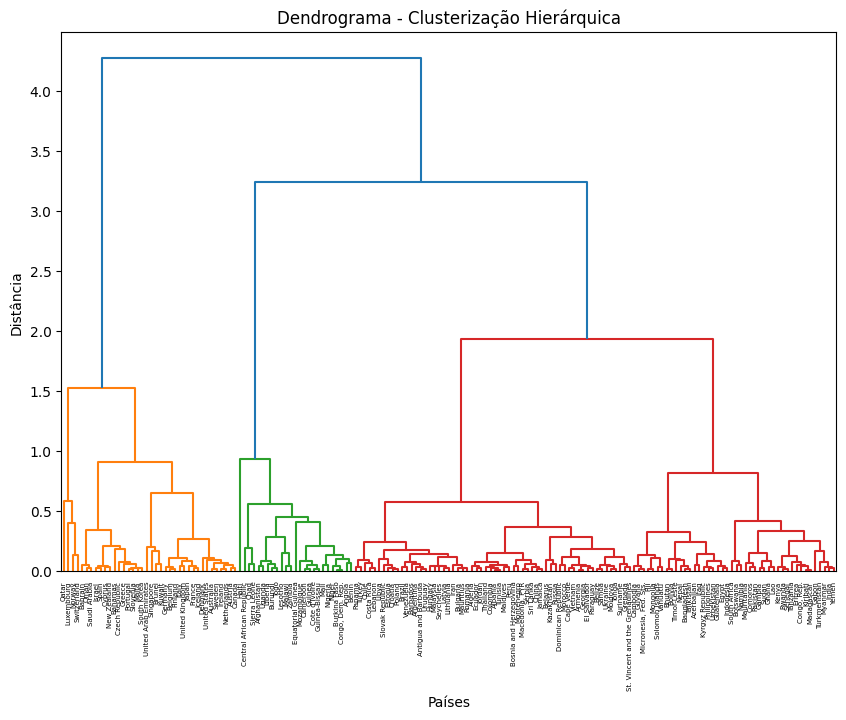

In [44]:
# Verificando se as colunas existem no DataFrame
missing_columns = [col for col in columns_to_scale if col not in df.columns]
if missing_columns:
    print(f"Colunas ausentes: {missing_columns}")
else:
    # Pré-processamento: Escalonando os dados
    min_max_scaler = MinMaxScaler()
    df_scaled = min_max_scaler.fit_transform(df[columns_to_scale])

    # Realizando a clusterização hierárquica
    hierarchical_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
    df['cluster'] = hierarchical_clustering.fit_predict(df_scaled)

    # Gerando o dendrograma
    Z = linkage(df_scaled, method='ward')
    labels_hierarchical = fcluster(Z, t=3, criterion='maxclust')

    # Plotando o dendrograma
    plt.figure(figsize=(10, 7))
    dendrogram(Z, labels=df['country'].values)  # Alterado para usar a coluna 'country' com a lista de países
    plt.title('Dendrograma - Clusterização Hierárquica')
    plt.xlabel('Países')
    plt.ylabel('Distância')
    plt.show()

    # Exibindo as primeiras linhas de Z para análise
    Z_df = pd.DataFrame(Z, columns=['Cluster 1', 'Cluster 2', 'Distância', 'Tamanho do Cluster'])
    #print("Matriz de linkage (primeiras linhas):")
    #print(Z_df.head())
    
    # Opcional: Exibindo o número de clusters (alterando o ponto de corte)
    n_clusters = 3  # Definindo o número de clusters desejados
    cluster_labels_hierarchical = pd.cut(Z_df['Distância'], bins=n_clusters, labels=[f'Cluster {i+1}' for i in range(n_clusters)])
    
    # Adicionando as labels de cluster na matriz Z para visualização
    Z_df['Cluster'] = cluster_labels_hierarchical
    #print("\nMatriz de linkage com clusters atribuídos:")
    #print(Z_df.head())

<span style="color:blue;">

##### Interpretação dos resultados:

No começo, os países com características mais parecidas se unem, formando grupos pequenos com distâncias curtas (menor valor na coluna "Distância"). Com o tempo, os grupos vão ficando maiores e as distâncias entre eles aumentam.

Atribuição de Clusters: Cada grupo de países foi atribuído a um "Cluster". No início, todos os países estão no Cluster 1, mas à medida que os agrupamentos acontecem, os países se distribuem nos três clusters.

</span>

### 4. Compare os dois resultados, aponte as semelhanças e diferenças e interprete.

<span style="color:blue;">

### Comparação:
##### K-Médias:
Ele divide os países em 3 grupos fixos (clusters), de acordo com suas características (renda, mortalidade infantil, etc.).

##### Clusterização Hierárquica:
Ela começa com cada país como seu próprio cluster e vai combinando-os aos poucos com base nas distâncias entre eles, criando uma estrutura de árvore (dendrograma) que mostra como os grupos se formam.


### Semelhanças:
##### Distribuição das variáveis:
Em ambos os métodos, os Cluster 1 (mais desenvolvido) têm países com alta renda, expectativa de vida e PIB per capita. O Cluster 2 (menos desenvolvido) tem países com baixos valores em todos esses aspectos.

##### Países representativos:
Nos dois métodos, países como Australia, Albania, Argentina, Afghanistan aparecem em clusters semelhantes.


### Diferenças:
##### K-Médias
Já define 3 grupos e atribui países a eles diretamente.
Forma os grupos de uma vez.

##### Clusterização Hierárquica
Não define a quantidade de grupos, e você pode cortar o dendrograma em diferentes pontos para criar grupos de diferentes tamanhos.
Forma grupos aos poucos e você pode ver como os países são agrupados no dendrograma.


### Interpretação:
##### K-Médias:
Ele dá uma divisão clara em 3 grupos e mostra quais países estão mais perto uns dos outros em termos de desenvolvimento.

##### Clusterização Hierárquica:
Ela permite ver o "processo" de como os países vão se agrupando, e você pode escolher onde cortar para formar os grupos, dependendo do seu critério.

</span>

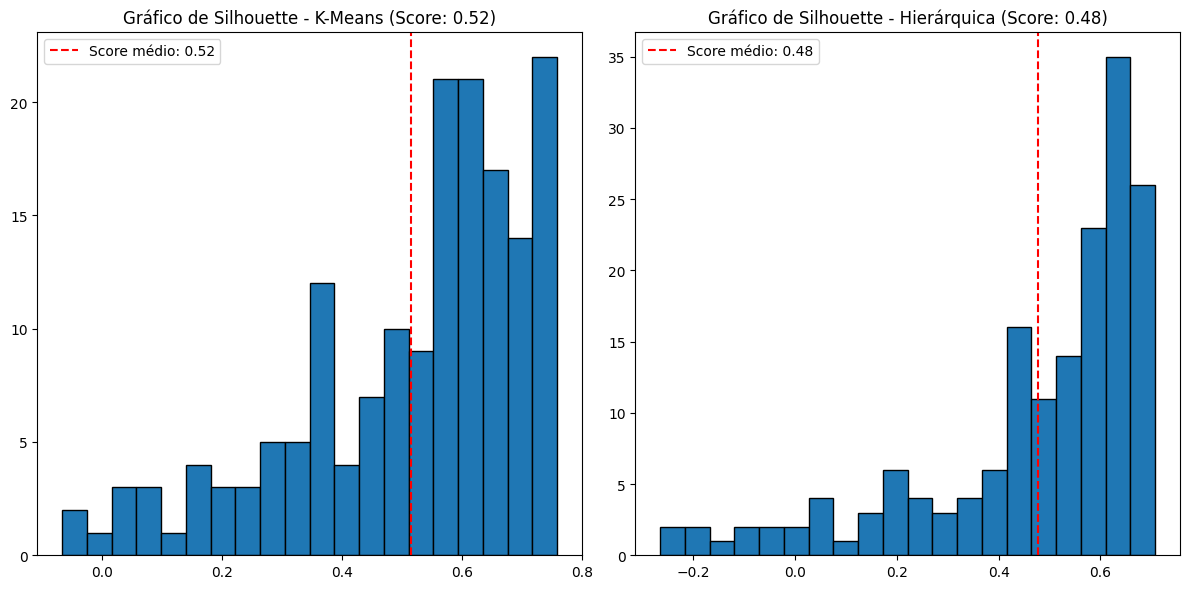

In [48]:
# Calcular as pontuações de silhouette
silhouette_kmeans = silhouette_samples(X, labels_kmeans)
score_kmeans = silhouette_score(X, labels_kmeans)

silhouette_hierarchical = silhouette_samples(X, labels_hierarchical)
score_hierarchical = silhouette_score(X, labels_hierarchical)

# Plotando os gráficos de Silhouette
plt.figure(figsize=(12, 6))

# Gráfico para K-Means
plt.subplot(1, 2, 1)
plt.title(f'Gráfico de Silhouette - K-Means (Score: {score_kmeans:.2f})')
plt.hist(silhouette_kmeans, bins=20, edgecolor='black')
plt.axvline(x=score_kmeans, color='red', linestyle='--', label=f'Score médio: {score_kmeans:.2f}')
plt.legend()

# Gráfico para Clusterização Hierárquica
plt.subplot(1, 2, 2)
plt.title(f'Gráfico de Silhouette - Hierárquica (Score: {score_hierarchical:.2f})')
plt.hist(silhouette_hierarchical, bins=20, edgecolor='black')
plt.axvline(x=score_hierarchical, color='red', linestyle='--', label=f'Score médio: {score_hierarchical:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

---

Parte 4 - Escolha de algoritmos
======================

### 1. Escreva em tópicos as etapas do algoritmo de K-médias até sua convergência.

<span style="color:blue;">
    
##### Etapa 1. Escolher o número de clusters (K):

###### -> Decide quantos grupos você quer criar.

##### Etapa 2. Escolher centros iniciais (centroides):

###### -> Coloca os centros iniciais dos grupos (esses centros podem ser aleatórios).

##### Etapa 3. Atribuir cada ponto ao cluster mais próximo:

###### -> Para cada ponto (ou país, empresa, etc.), calcula a distância até cada centro.
###### -> Coloca o ponto no grupo do centro mais perto.

##### Etapa 4. Recalcular os centros dos clusters:

###### -> Depois de agrupar os pontos, recalcula o centro de cada grupo (isso se faz calculando a média dos pontos em cada cluster).

##### Etapa 5. Repetir as etapas 3 e 4:

###### -> Atribui novamente cada ponto ao centro mais próximo.
###### -> Recalcula os centros outra vez.

##### Etapa 6. Parar quando não houver mudanças (convergência):

###### -> O algoritmo continua até que os centros não mudem mais de posição, ou a mudança seja muito pequena.

</span>

### 2. O algoritmo de K-médias converge até encontrar os centróides que melhor descrevem os clusters encontrados (até o deslocamento entre as interações dos centróides ser mínimo). Lembrando que o centróide é o baricentro do cluster em questão e não representa, em via de regra, um dado existente na base. 

#### Refaça o algoritmo apresentado na questão 1 a fim de garantir que o cluster seja representado pelo dado mais próximo ao seu baricentro em todas as iterações do algoritmo.
#### Obs. nesse novo algoritmo, o dado escolhido será chamado medóide.

.

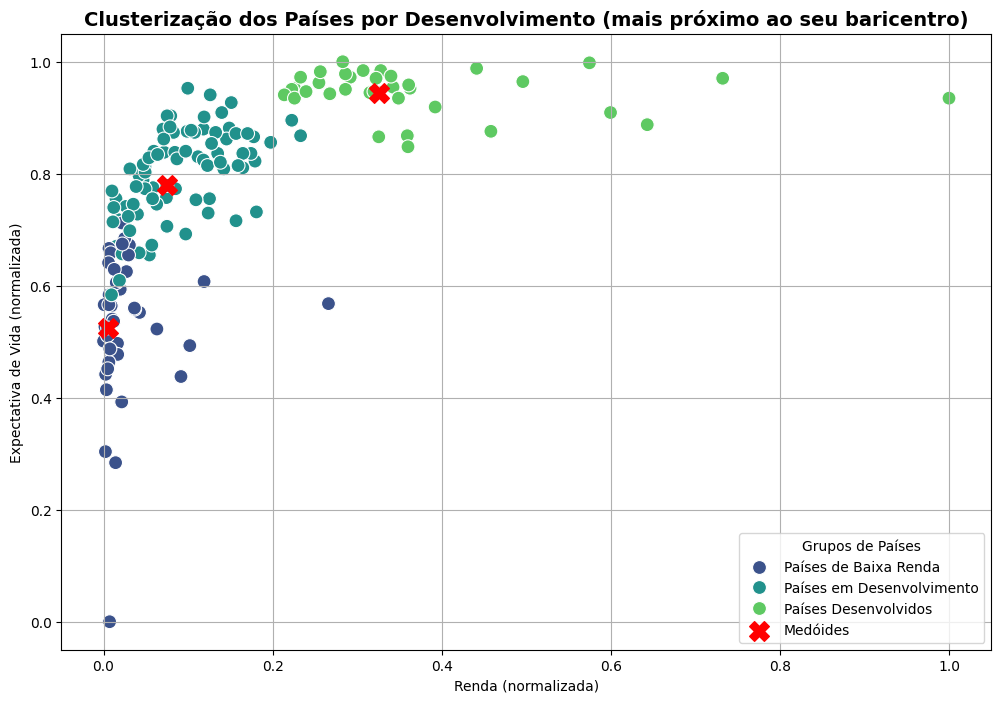

Silhouette Score: 0.515767362127356


In [53]:
os.environ["LOKY_MAX_CPU_COUNT"] = "2"  # núcleos desejado

# Selecionando as colunas relevantes para a clusterização
columns_to_scale = ['child_mort', 'income', 'life_expec', 'gdpp']
X = df[columns_to_scale]

# Normalizando as colunas para a clusterização
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

# Inicializando o modelo KMeans com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Loop para realizar as atualizações até a convergência
converged = False
max_iter = 100  # número máximo de iterações
iteration = 0

while not converged and iteration < max_iter:
    # Atribuindo os pontos aos clusters
    old_centroids = kmeans.cluster_centers_.copy()
    
    # Para cada cluster, encontramos o medóide (ponto mais próximo do centróide)
    for i in range(kmeans.n_clusters):
        # Pegamos os pontos que estão no cluster 'i'
        cluster_points = X_scaled[labels_kmeans == i]
        
        # Calculamos o baricentro (centróide) do cluster
        centroid = kmeans.cluster_centers_[i]
        
        # Calculamos a distância dos pontos ao baricentro
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        
        # Encontramos o ponto mais próximo do centróide (medóide)
        medoid_idx = np.argmin(distances)
        medoid = cluster_points[medoid_idx]
        
        # Substituímos o centróide pelo medóide
        kmeans.cluster_centers_[i] = medoid
    
    # Recalcular os rótulos de cluster com os novos centróides
    labels_kmeans = kmeans.predict(X_scaled)
    
    # Verificar se os centróides não mudaram muito, ou seja, o algoritmo convergiu
    centroid_shift = np.linalg.norm(kmeans.cluster_centers_ - old_centroids)
    
    # Se a mudança for muito pequena, consideramos a convergência
    if centroid_shift < 1e-6:
        converged = True
    
    iteration += 1

# Atribuindo os rótulos finais aos dados
df['cluster_kmeans'] = labels_kmeans

# Visualizando os centros dos clusters (medóides)
centroids = kmeans.cluster_centers_

# Calculando a média das variáveis para cada cluster, para análise
cluster_summary = df.groupby('cluster_kmeans')[columns_to_scale].mean()

# Definindo rótulos baseados na interpretação das características médias
cluster_labels = {
    0: "Países em Desenvolvimento",
    1: "Países Desenvolvidos",
    2: "Países de Baixa Renda"
}

# Atribuindo rótulos descritivos aos clusters
df['Cluster_Descrição'] = df['cluster_kmeans'].map(cluster_labels)

# Plotando os clusters com os rótulos interpretativos
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df[columns_to_scale[1]],  # 'income'
    y=df[columns_to_scale[2]],  # 'life_expec'
    hue=df['Cluster_Descrição'],
    palette='viridis',
    s=100
)

# Adicionando os medóides ao gráfico
plt.scatter(
    centroids[:, 1],  # 'income'
    centroids[:, 2],  # 'life_expec'
    c='red',
    marker='X',
    s=200,
    label='Medóides'
)

plt.title("Clusterização dos Países por Desenvolvimento (mais próximo ao seu baricentro)", fontweight='bold', fontsize=14)
plt.xlabel('Renda (normalizada)')
plt.ylabel('Expectativa de Vida (normalizada)')
plt.legend(title="Grupos de Países")
plt.grid(True)
plt.show()

# Calculando e exibindo o Silhouette Score
silhouette_avg = silhouette_score(X_scaled, df['cluster_kmeans'])
print(f"Silhouette Score: {silhouette_avg}")

### 3. O algoritmo de K-médias é sensível a outliers nos dados. Explique.

<span style="color:blue;">
    
##### O algoritmo de K-médias é sensível a outliers porque ele tenta minimizar a distância entre os pontos e os centróides. Isso significa que, se houver dados muito diferentes ou distantes do resto, o algoritmo pode ajustar os centróides de forma errada, colocando-os em posições que não representam bem o grupo de dados.

##### Por exemplo, se um ponto de dados está muito distante dos outros, o centróide pode ser puxado para perto desse ponto, o que acaba distorcendo a formação do cluster e fazendo com que o algoritmo não encontre bons agrupamentos. Em resumo, os outliers podem causar erros nos resultados do K-means, pois ele tenta "forçar" os dados a se encaixarem no modelo de clusters, mesmo que isso não seja o mais adequado para o conjunto como um todo.

##### Uma forma de lidar com isso é remover os outliers antes de rodar o algoritmo ou usar outros métodos de clusterização que sejam menos sensíveis a esses valores.

### 4. Por que o algoritmo de DBScan é mais robusto à presença de outliers?

Number of clusters (excluding noise): 1
Number of labels (including noise): 2
Número de ruídos (outliers): 26


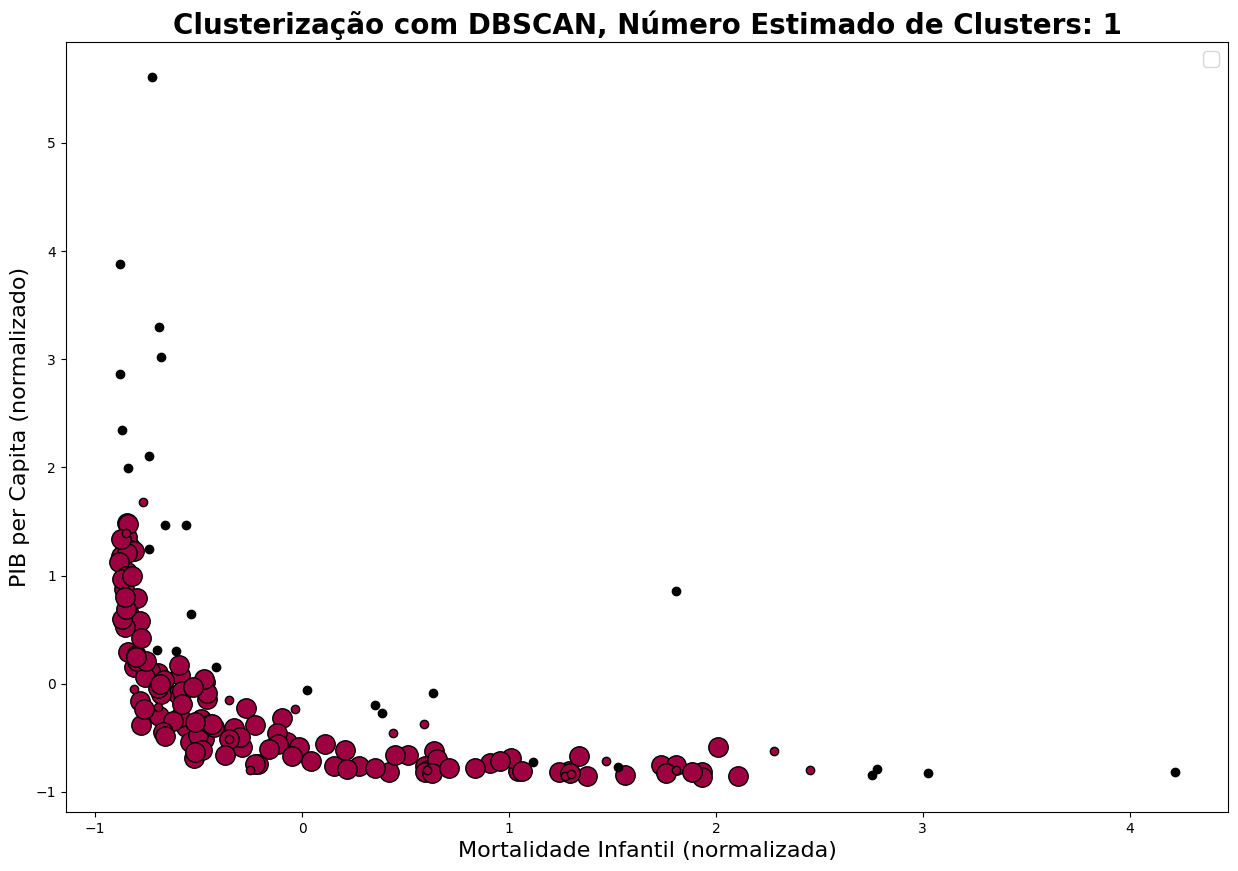

In [57]:
# Selecionando as variáveis relevantes para a clusterização
X = df[['child_mort', 'income', 'life_expec', 'gdpp']]

# Substituindo NaN por 0, se necessário (já feito anteriormente no pré-processamento)
X = np.nan_to_num(X)

# Convertendo os dados para tipo float64 e normalizando
X = np.array(X, dtype=np.float64)
X = StandardScaler().fit_transform(X)

# Computando o DBSCAN
db = DBSCAN(eps=0.4, min_samples=5).fit(X)

# Máscara de pontos principais (núcleos)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Labels gerados pelo DBSCAN
labels = db.labels_

# Adicionando os rótulos de cluster ao DataFrame
df['Clus_Db'] = labels

# Contando o número de clusters reais (excluindo o rótulo -1, que indica ruído)
realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters (excluding noise): {realClusterNum}")

# Número de rótulos
print("Number of labels (including noise):", len(set(labels)))

# Contando o número de pontos classificados como ruído (-1)
n_noise_ = list(labels).count(-1)
print(f'Número de ruídos (outliers): {n_noise_}')

# Gráfico de DBSCAN com cores diferentes para cada cluster
plt.figure(figsize=(15, 10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Preto para ruído
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title(f'Clusterização com DBSCAN, Número Estimado de Clusters: {realClusterNum}', fontweight='bold', fontsize=20)
plt.xlabel('Mortalidade Infantil (normalizada)', fontsize=16)
plt.ylabel('PIB per Capita (normalizado)', fontsize=16)
plt.legend(fontsize=14)
plt.show()

<span style="color:blue;">
    
##### O algoritmo DBSCAN é mais robusto à presença de outliers porque, ao contrário do K-means, ele agrupa os dados com base na densidade, identificando pontos isolados como ruído (rótulo -1).

##### No meu conjunto de dados, a maioria dos países foi agrupada em um único cluster (141 países), enquanto 26 países foram classificados como outliers (ruído), como Azerbaijão, Bahamas e Zâmbia, devido às suas características distintas.
    
##### Isso mostra como o DBSCAN lida bem com outliers, não forçando-os a integrar o cluster, ao contrário do K-means.